In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df = prepare.remove_outliers(df)

In [4]:
df = prepare.handle_nulls(df)

In [5]:
df = prepare.rename_columns(df)

In [6]:
df = prepare.prepare_locs(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   47936 non-null  int64         
 1   bathrooms                  47936 non-null  float64       
 2   bedrooms                   47936 non-null  float64       
 3   square_feet                47936 non-null  int64         
 4   fips                       47936 non-null  int64         
 5   garages                    47936 non-null  int64         
 6   garage_size                47936 non-null  int64         
 7   lot_size                   47936 non-null  int64         
 8   has_pool                   47936 non-null  bool          
 9   propertycountylandusecode  47936 non-null  object        
 10  propertylandusetypeid      47936 non-null  float64       
 11  year_built                 47936 non-null  int64         
 12  log_

In [8]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [9]:
orange_train = train.where(train.county == 'orange')
orange_validate = validate.where(validate.county == 'orange')
orange_test = test.where(test.county == 'orange')

In [11]:
orange_train = orange_train.dropna()
orange_validate = orange_validate.dropna()
orange_test = orange_test.dropna()

In [12]:
orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 50705 to 1588
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   7368 non-null   float64       
 1   bathrooms                  7368 non-null   float64       
 2   bedrooms                   7368 non-null   float64       
 3   square_feet                7368 non-null   float64       
 4   fips                       7368 non-null   float64       
 5   garages                    7368 non-null   float64       
 6   garage_size                7368 non-null   float64       
 7   lot_size                   7368 non-null   float64       
 8   has_pool                   7368 non-null   object        
 9   propertycountylandusecode  7368 non-null   object        
 10  propertylandusetypeid      7368 non-null   float64       
 11  year_built                 7368 non-null   float64       
 12  lo

In [16]:
continuous_features = orange_train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size', 'year_built']]

In [17]:
discrete_features = orange_train[['has_pool', 'transaction_date', 'propertycountylandusecode']]

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

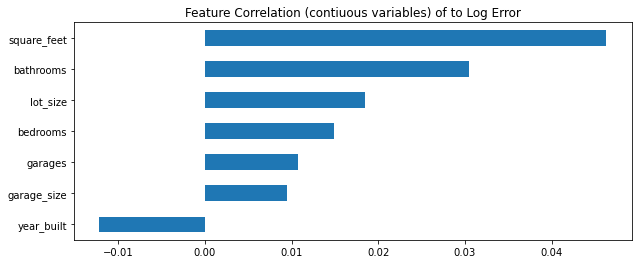

In [29]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = continuous_features.corrwith(orange_train['log_error']).sort_values().plot.barh()
corr_chart


- square feet, bathrooms, and year built - these 3 move on for modeling

In [31]:
discrete_features

has_pool transaction_date propertycountylandusecode
50705    False       2017-09-08                       122
7085     False       2017-02-17                       122
4560     False       2017-01-31                       122
24504    False       2017-05-16                       122
24460     True       2017-05-15                       122
...        ...              ...                       ...
16131     True       2017-04-06                       122
40484    False       2017-07-24                       122
7527      True       2017-02-21                       122
50318     True       2017-09-07                       122
1588     False       2017-01-11                       122

[7368 rows x 3 columns]

In [38]:
orange_train

parcelid  bathrooms  bedrooms  square_feet    fips  garages  \
50705  14414316.0        3.0       4.0       2104.0  6059.0      2.0   
7085   14037285.0        1.5       3.0       1032.0  6059.0      2.0   
4560   14496831.0        3.0       3.0       1299.0  6059.0      2.0   
24504  14473040.0        2.0       4.0       2109.0  6059.0      2.0   
24460  14057077.0        2.0       5.0       1982.0  6059.0      2.0   
...           ...        ...       ...          ...     ...      ...   
16131  14144893.0        2.5       4.0       2655.0  6059.0      2.0   
40484  14076657.0        2.0       3.0       1439.0  6059.0      2.0   
7527   13931397.0        2.0       3.0       1889.0  6059.0      2.0   
50318  14036755.0        2.0       4.0       1454.0  6059.0      2.0   
1588   13961990.0        3.0       5.0       2305.0  6059.0      2.0   

       garage_size  lot_size has_pool propertycountylandusecode  \
50705        441.0    4275.0    False                       122   
7085         441.0    6000.0    False                       122   
4560         440.0    3750.0    False                       122   
24504        475.0    8449.0    False                       122   
24460        506.0    6000.0     True                       122   
...            ...       ...      ...                       ...   
16131        493.0   19680.0     True                       122   
40484        460.0    5000.0    False                       122   
7527         400.0    8400.0     True                       122   
50318        451.0    6000.0     True                       122   
1588         416.0   13800.0    False                       122   

       propertylandusetypeid  year_built  log_error transaction_date  county  \
50705                  261.0      1977.0   0.019273       2017-09-08  orange   
7085                   261.0      1962.0  -0.013230       2017-02-17  orange   
4560                   261.0      1986.0  -0.000039       2017-01-31  orange   
24504                  261.0      1966.0   0.078144       2017-05-16  orange   
24460                  261.0      1964.0  -0.019793       2017-05-15  orange   
...                      ...         ...        ...              ...     ...   
16131                  261.0      1964.0  -0.000091       2017-04-06  orange   
40484                  261.0      1971.0  -0.055627       2017-07-24  orange   
7527                   261.0      1955.0   0.011196       2017-02-21  orange   
50318                  261.0      1963.0  -0.057559       2017-09-07  orange   
1588                   261.0      2007.0  -0.062614       2017-01-11  orange   

        latitude   longitude  
50705  33.554803 -117.701673  
7085   33.738875 -118.016219  
4560   33.651782 -117.576876  
24504  33.599907 -117.664683  
24460  33.677214 -117.952371  
...          ...         ...  
16131  33.894337 -117.939625  
40484  33.714278 -117.942550  
7527   33.798431 -117.951018  
50318  33.732223 -118.018982  
1588   33.743353 -117.805178  

[7368 rows x 17 columns]

In [35]:
import plotly.express as px

Text(0.5, 1.0, 'Land Code w/Cont.')

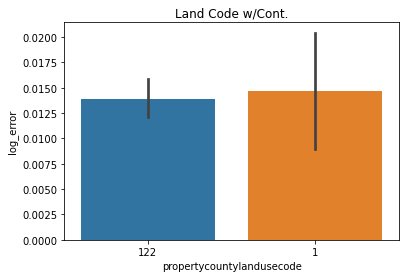

In [45]:
sns.barplot(data=orange_train, x='propertycountylandusecode', y='log_error')
plt.title("Land Code w/Cont.")

In [46]:
orange_train.propertycountylandusecode.value_counts()

122    6863
1       505
Name: propertycountylandusecode, dtype: int64

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

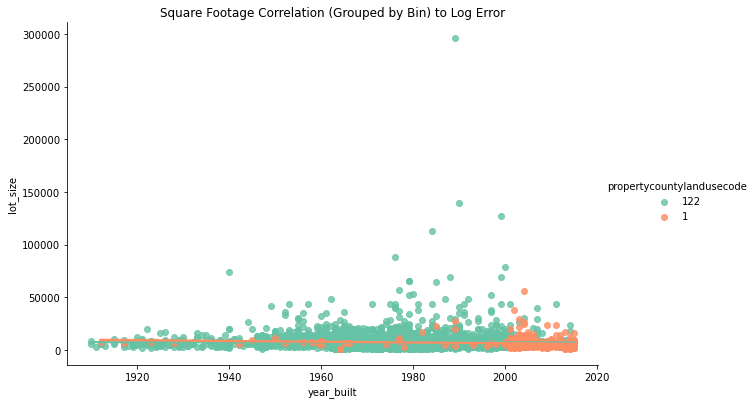

In [64]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='lot_size', data=orange_train, scatter=True, hue='propertycountylandusecode', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [66]:
#log error for square foot less than 2000 in 122 is problem
#1960
#with 2-4 br

In [72]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).describe()

parcelid    bathrooms     bedrooms  square_feet    fips  \
count  6.863000e+03  6863.000000  6863.000000  6863.000000  6863.0   
mean   1.418608e+07     2.375127     3.418330  1976.051435  6059.0   
std    1.981944e+05     0.720478     0.801846   773.033827     0.0   
min    1.383453e+07     1.000000     1.000000   653.000000  6059.0   
25%    1.401427e+07     2.000000     3.000000  1392.000000  6059.0   
50%    1.418736e+07     2.000000     3.000000  1804.000000  6059.0   
75%    1.437103e+07     3.000000     4.000000  2398.000000  6059.0   
max    1.476274e+07     5.000000     5.000000  5494.000000  6059.0   

           garages  garage_size       lot_size  propertylandusetypeid  \
count  6863.000000  6863.000000    6863.000000                 6863.0   
mean      1.856040   470.832872    7157.344019                  261.0   
std       0.576395   158.169884    6544.453894                    0.0   
min       0.000000     0.000000     540.000000                  261.0   
25%       2.000000   420.000000    5000.000000                  261.0   
50%       2.000000   460.000000    6458.000000                  261.0   
75%       2.000000   520.000000    7902.000000                  261.0   
max      14.000000  4251.000000  296208.000000                  261.0   

        year_built    log_error     latitude    longitude  
count  6863.000000  6863.000000  6863.000000  6863.000000  
mean   1971.848754     0.013903    33.721631  -117.837948  
std      16.273032     0.076180     0.126055     0.135150  
min    1910.000000    -0.309399    33.393644  -118.111451  
25%    1961.000000    -0.018369    33.632048  -117.950374  
50%    1971.000000     0.007192    33.732138  -117.856701  
75%    1984.000000     0.035526    33.824317  -117.714816  
max    2015.000000     0.491767    33.945897  -117.554636

In [73]:
(orange_train.where(orange_train.propertycountylandusecode == '1')).describe()

parcelid   bathrooms    bedrooms  square_feet    fips     garages  \
count  5.050000e+02  505.000000  505.000000   505.000000   505.0  505.000000   
mean   1.427168e+07    3.271287    3.772277  2861.055446  6059.0    2.000000   
std    1.908072e+05    0.808970    0.699790   830.189647     0.0    0.345033   
min    1.383882e+07    1.000000    2.000000   902.000000  6059.0    0.000000   
25%    1.415672e+07    2.500000    3.000000  2283.000000  6059.0    2.000000   
50%    1.432801e+07    3.000000    4.000000  2777.000000  6059.0    2.000000   
75%    1.445362e+07    4.000000    4.000000  3451.000000  6059.0    2.000000   
max    1.476217e+07    5.000000    5.000000  5438.000000  6059.0    4.000000   

       garage_size      lot_size  propertylandusetypeid   year_built  \
count   505.000000    505.000000                  505.0   505.000000   
mean    514.097030   6201.013861                  261.0  2003.653465   
std     118.694538   4531.934806                    0.0    12.378966   
min       0.000000   1027.000000                  261.0  1912.000000   
25%     428.000000   3812.000000                  261.0  2003.000000   
50%     466.000000   5232.000000                  261.0  2005.000000   
75%     611.000000   7187.000000                  261.0  2009.000000   
max     889.000000  56280.000000                  261.0  2015.000000   

        log_error    latitude   longitude  
count  505.000000  505.000000  505.000000  
mean     0.014645   33.683871 -117.779306  
std      0.067993    0.144146    0.131958  
min     -0.266302   33.423443 -118.107041  
25%     -0.014907   33.550964 -117.869508  
50%      0.008090   33.681750 -117.770978  
75%      0.033477   33.786391 -117.643618  
max      0.497845   33.935358 -117.576924

In [134]:
orange_train.garages.value_counts()

2.0     6018
1.0      929
0.0      193
3.0      173
4.0       40
5.0        5
6.0        4
9.0        2
8.0        2
14.0       1
7.0        1
Name: garages, dtype: int64

Because there are so few properties that have 3+ garages, I'm turning this into a boolean of yes/no garage and dropping garage size.

In [137]:
orange_train['garages'] = orange_train.garages.astype(bool)

In [139]:
orange_train.garages.value_counts()

True     7175
False     193
Name: garages, dtype: int64

In [143]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).groupby(orange_train.garages).sum()

parcelid  bathrooms  bedrooms  square_feet        fips  \
garages                                                               
False    2.699469e+09      309.5     492.0     250571.0   1157269.0   
True     9.465960e+10    15991.0   22968.0   13311070.0  40425648.0   

         garage_size    lot_size  propertylandusetypeid  year_built  \
garages                                                               
False            0.0   1112177.0                49851.0    373844.0   
True       3231326.0  48008675.0              1741392.0  13158954.0   

         log_error       latitude      longitude  scalbathrooms  scalbedrooms  \
garages                                                                         
False     1.176072    6442.248523  -22511.802586         29.625         75.25   
True     94.238509  224989.303754 -786210.037579       2329.750       4074.00   

         scalsquare_feet  cluster  
garages                            
False          25.996282    405.0  
True         1849.670316  11090.0

pretty much all of the homes in code 1 have garages. 

In [171]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [175]:
orange_train_neg.groupby(orange_train_neg.has_pool).mean()

parcelid  bathrooms  bedrooms  square_feet    fips  garage_size  \
has_pool                                                                        
False     1.417279e+07   2.293339  3.299956  1839.379356  6059.0   447.570798   
True      1.418992e+07   2.630573  3.707006  2364.877707  6059.0   526.593631   

              lot_size  propertylandusetypeid   year_built  log_error  \
has_pool                                                                
False      6133.367887                  261.0  1972.912219  -0.037477   
True      10007.952866                  261.0  1972.722293  -0.044639   

           latitude   longitude  scalbathrooms  scalbedrooms  scalsquare_feet  \
has_pool                                                                        
False     33.721348 -117.845889       0.323335      0.574989         0.245069   
True      33.727188 -117.834965       0.407643      0.676752         0.353621   

           cluster  
has_pool            
False     1.653727  
True      1.617834

In [194]:
orange_train_neg.describe()

parcelid    bathrooms     bedrooms  square_feet    fips  \
count  3.052000e+03  3052.000000  3052.000000  3052.000000  3052.0   
mean   1.417720e+07     2.380079     3.404653  1974.541940  6059.0   
std    1.996568e+05     0.732741     0.794783   765.181423     0.0   
min    1.383469e+07     1.000000     1.000000   664.000000  6059.0   
25%    1.400424e+07     2.000000     3.000000  1391.000000  6059.0   
50%    1.417343e+07     2.000000     3.000000  1795.000000  6059.0   
75%    1.435818e+07     3.000000     4.000000  2419.000000  6059.0   
max    1.476194e+07     5.000000     5.000000  5422.000000  6059.0   

       garage_size       lot_size  propertylandusetypeid   year_built  \
count  3052.000000    3052.000000                 3052.0  3052.000000   
mean    467.896134    7129.943644                  261.0  1972.863368   
std     149.232792    7566.669736                    0.0    18.022765   
min       0.000000     540.000000                  261.0  1910.000000   
25%     420.000000    5000.000000                  261.0  1960.000000   
50%     460.000000    6444.500000                  261.0  1971.000000   
75%     510.000000    7924.250000                  261.0  1986.000000   
max    2632.000000  296208.000000                  261.0  2015.000000   

         log_error     latitude    longitude  scalbathrooms  scalbedrooms  \
count  3052.000000  3052.000000  3052.000000    3052.000000   3052.000000   
mean     -0.039319    33.722850  -117.843079       0.345020      0.601163   
std       0.046712     0.125060     0.134107       0.183185      0.198696   
min      -0.309399    33.402263  -118.109060       0.000000      0.000000   
25%      -0.047533    33.635377  -117.954512       0.250000      0.500000   
50%      -0.024393    33.735085  -117.864401       0.250000      0.500000   
75%      -0.010625    33.822803  -117.727038       0.500000      0.750000   
max      -0.000012    33.945806  -117.559828       1.000000      1.000000   

       scalsquare_feet      cluster  
count      3052.000000  3052.000000  
mean          0.272989     1.644495  
std           0.158063     1.680598  
min           0.002272     0.000000  
25%           0.152448     0.000000  
50%           0.235902     1.000000  
75%           0.364801     4.000000  
max           0.985127     4.000000

In [216]:
orange_train['has_pool'] = orange_train.has_pool.astype(int)

In [428]:
bins = [-.6, -.0475, -.0244, -.0106, 0, .0125, .0283, .0586, .6]
labels = ['N4','N3','N2','N1', 'P1', 'P2', 'P3', 'P4']
orange_train['log_error_bin'] = pd.cut(orange_train['log_error'], bins=bins, labels=labels)
orange_validate['log_error_bin'] = pd.cut(orange_validate['log_error'], bins=bins, labels=labels)
orange_test['log_error_bin'] = pd.cut(orange_test['log_error'], bins=bins, labels=labels)

In [242]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [259]:
orange_train.groupby(orange_train.log_error_bin == 'N4').max()

parcelid  bathrooms  bedrooms  square_feet    fips  garages  \
log_error_bin                                                                  
False          14762744.0        5.0       5.0       5494.0  6059.0     True   
True           14761942.0        5.0       5.0       4827.0  6059.0     True   

               garage_size  lot_size  has_pool propertycountylandusecode  \
log_error_bin                                                              
False               4251.0  139392.0         1                       122   
True                2632.0  296208.0         1                       122   

               propertylandusetypeid  year_built  log_error transaction_date  \
log_error_bin                                                                  
False                          261.0      2015.0   0.497845       2017-09-18   
True                           261.0      2014.0  -0.047509       2017-09-15   

               county   latitude   longitude  scalbathrooms  scalbedrooms  \
log_error_bin                                                               
False          orange  33.945897 -117.554636            1.0           1.0   
True           orange  33.944791 -117.559828            1.0           1.0   

               scalsquare_feet  cluster log_error_bins log_error_bin  
log_error_bin                                                         
False                 1.000000        4             P4            P4  
True                  0.862219        4             N4            N4

In [260]:
bins = [0, .0125, .0283, .0586, .6]
labels = ['P1', 'P2', 'P3', 'P4']
orange_train_pos['log_error_bin'] = pd.cut(orange_train_pos['log_error'], bins=bins, labels=labels)

In [261]:
bins = [-.6, -.0475, -.0244, -.0106, 0.01]
labels = ['N4','N3','N2','N1']
orange_train_neg['log_error_bin'] = pd.cut(orange_train_neg['log_error'], bins=bins, labels=labels)

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

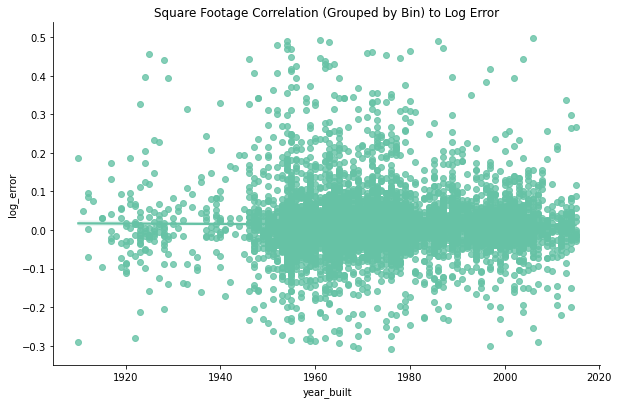

In [282]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train, scatter=True, col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

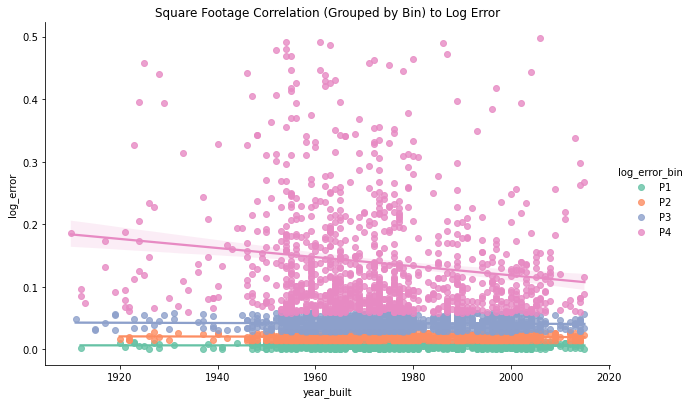

In [262]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

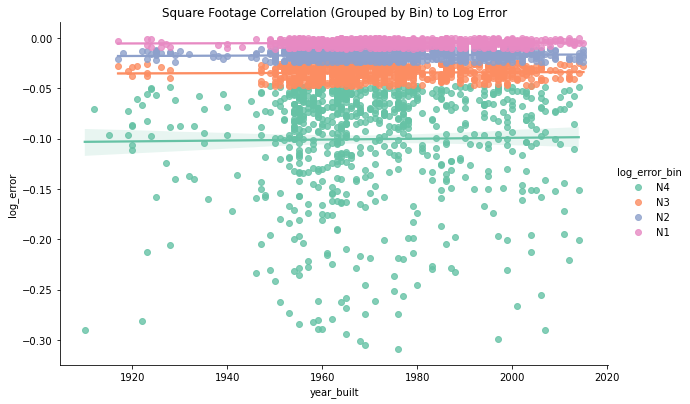

In [280]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='log_error', data=orange_train_neg, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

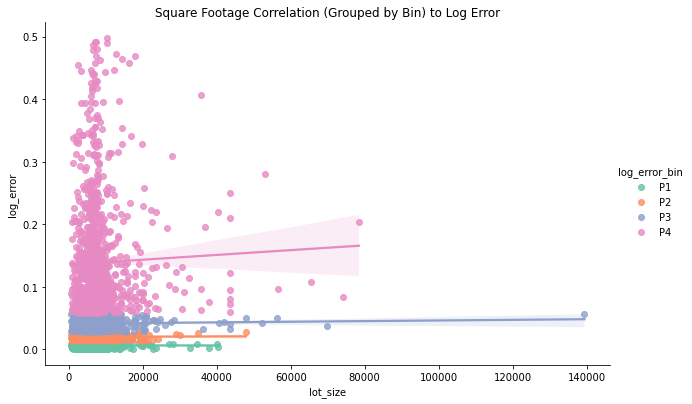

In [279]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

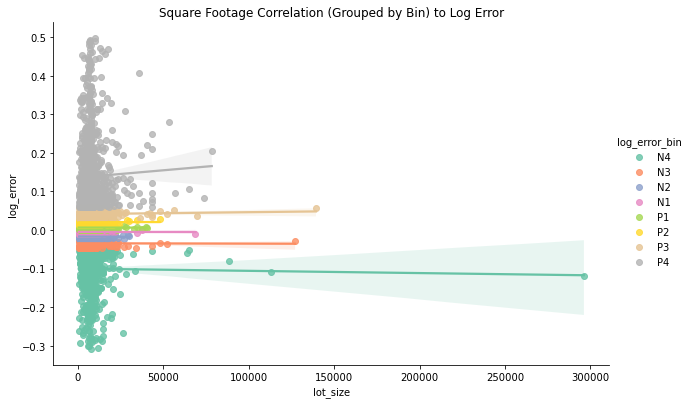

In [283]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [291]:
orange_train = orange_train[orange_train.lot_size < 200000]
orange_validate = orange_validate[orange_validate.lot_size < 200000]
orange_test = orange_test[orange_test.lot_size < 200000]
orange_train_pos = orange_train_pos[orange_train_pos.lot_size < 200000]
orange_train_neg = orange_train_neg[orange_train_neg.lot_size < 200000]

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

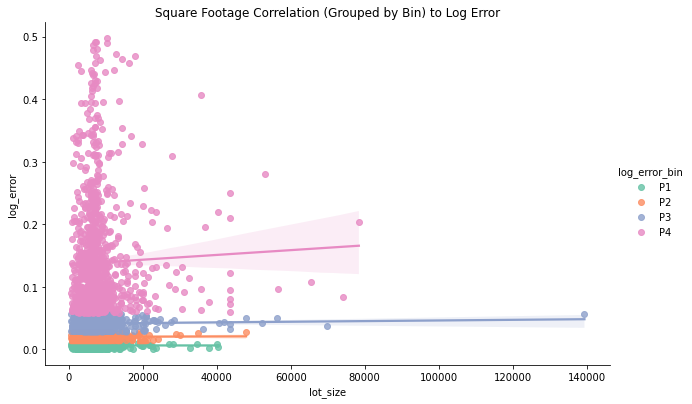

In [293]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='lot_size', y='log_error', data=orange_train_pos, scatter=True, hue='log_error_bin', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

KeyboardInterrupt: 

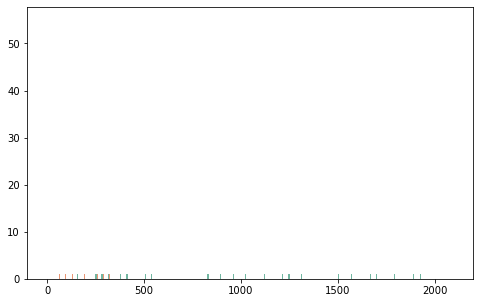

<AxesSubplot:title={'center':'Feature Correlation to Churn'}>

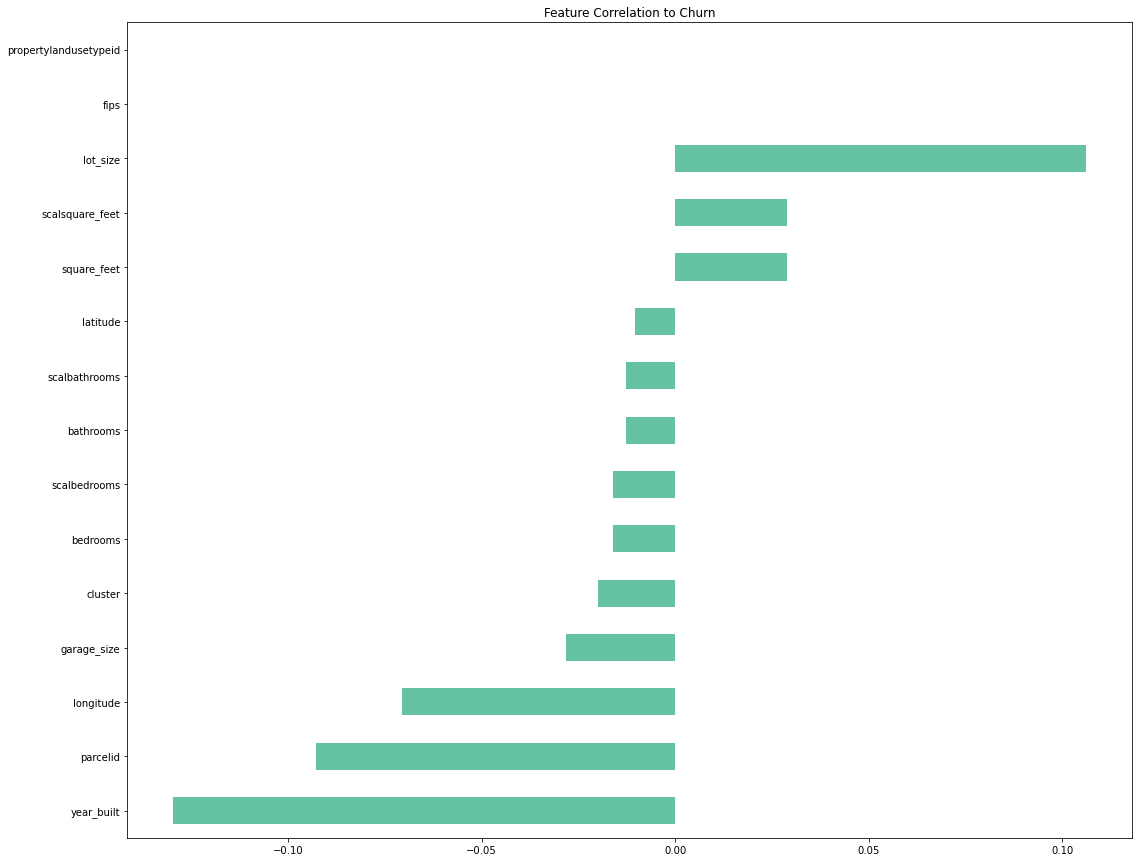

In [344]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train_pos.drop("log_error", axis=1).corrwith(orange_train_pos['log_error']).sort_values().plot.barh()
corr_chart

In [346]:
orange_train['weight_lot'] = orange_train['lot_size'] * 3.5
orange_validate['weight_lot'] = orange_validate['lot_size'] * 3.5
orange_test['weight_lot'] = orange_test['lot_size'] * 3.5

In [348]:
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(orange_train[['weight_lot', 'square_feet']])

StandardScaler()

In [350]:
orange_train[['scallot', 'scalsquare']] = scaler.transform(orange_train[['weight_lot', 'square_feet']])

In [351]:
orange_validate[['scallot', 'scalsquare']] = scaler.transform(orange_validate[['weight_lot', 'square_feet']])
orange_test[['scallot', 'scalsquare']] = scaler.transform(orange_test[['weight_lot', 'square_feet']])

In [352]:
orange_train['sqft'] = (orange_train.scallot + orange_train.scalsquare) / 2
orange_validate['sqft'] = (orange_validate.scallot + orange_validate.scalsquare) / 2
orange_test['sqft'] = (orange_test.scallot + orange_test.scalsquare) / 2

In [353]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

In [354]:
datap1 = orange_train_pos[orange_train_pos.log_error_bin == 'P1']
datap2 = orange_train_pos[orange_train_pos.log_error_bin == 'P2']
datap3 = orange_train_pos[orange_train_pos.log_error_bin == 'P3']
datap4 = orange_train_pos[orange_train_pos.log_error_bin == 'P4']

In [355]:
datan1 = orange_train_neg[orange_train_neg.log_error_bin == 'N1']
datan2 = orange_train_neg[orange_train_neg.log_error_bin == 'N2']
datan3 = orange_train_neg[orange_train_neg.log_error_bin == 'N3']
datan4 = orange_train_neg[orange_train_neg.log_error_bin == 'N4']

In [316]:
dp1 = datap1[['bedrooms', 'bathrooms', 'sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp2 = datap2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dp3 = datap3[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dp4 = datap4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [356]:
dn1 = datan1[['bedrooms', 'bathrooms','sqft', 'square_feet', 'lot_size', 'year_built', 'log_error']]
dn2 = datan2[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn3 = datan3[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]
dn4 = datan4[['bedrooms', 'bathrooms', 'sqft','square_feet', 'lot_size', 'year_built', 'log_error']]

In [357]:
data_pos = orange_train_pos[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]
data_neg = orange_train_neg[['bedrooms', 'sqft', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'log_error']]

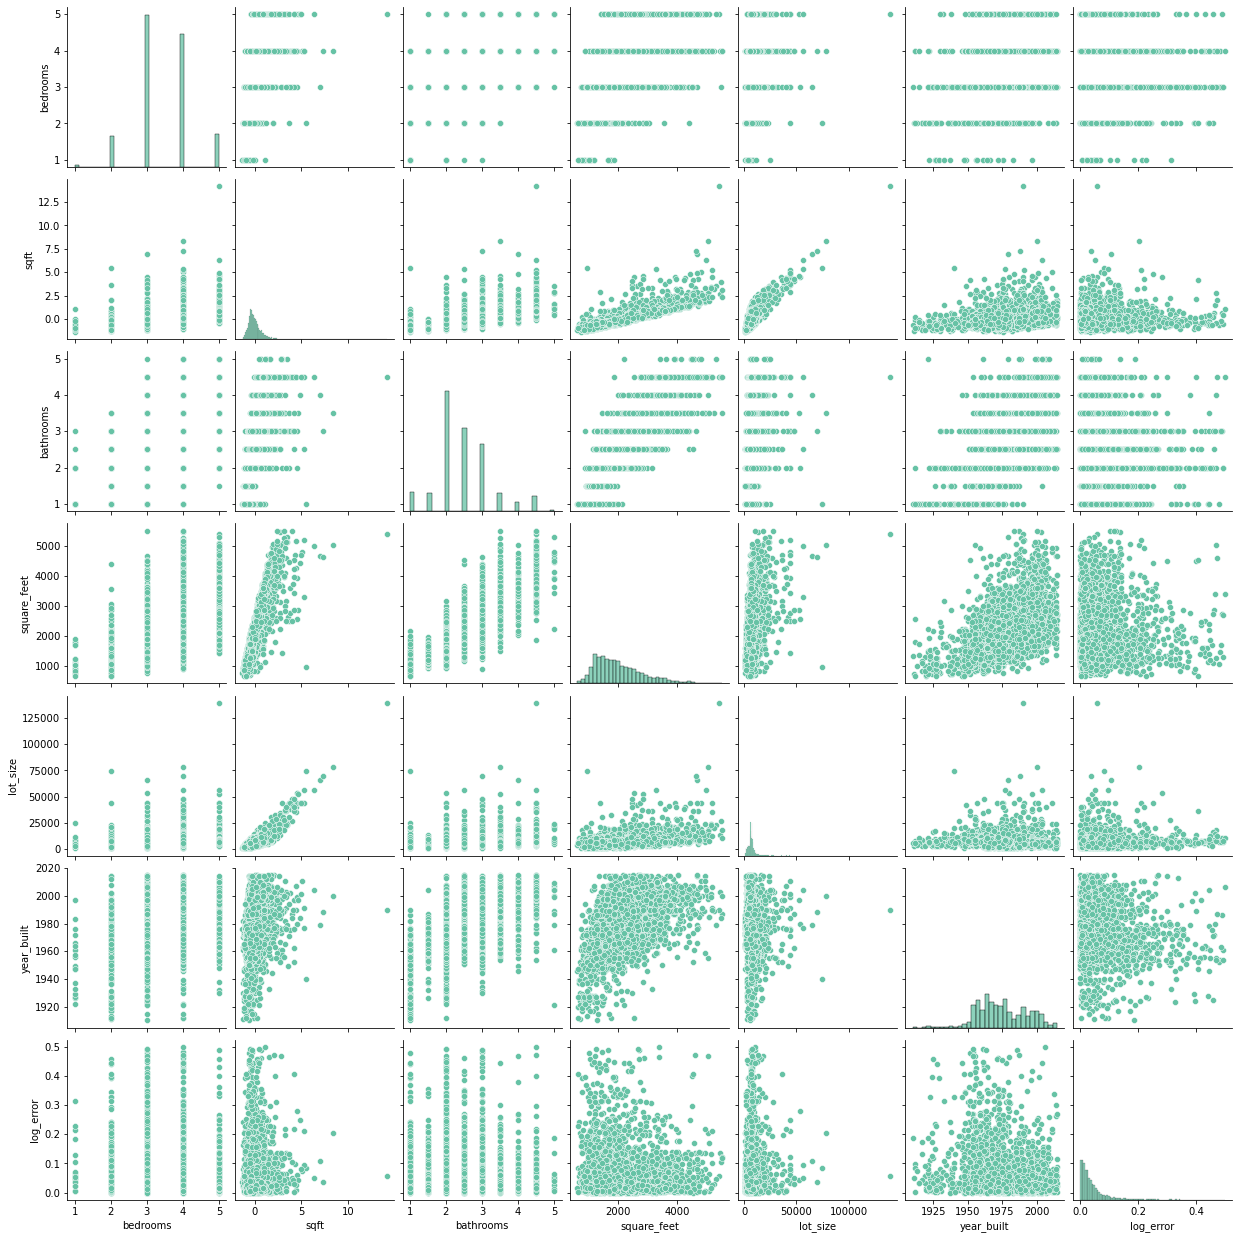

In [358]:
sns.pairplot(data_pos)

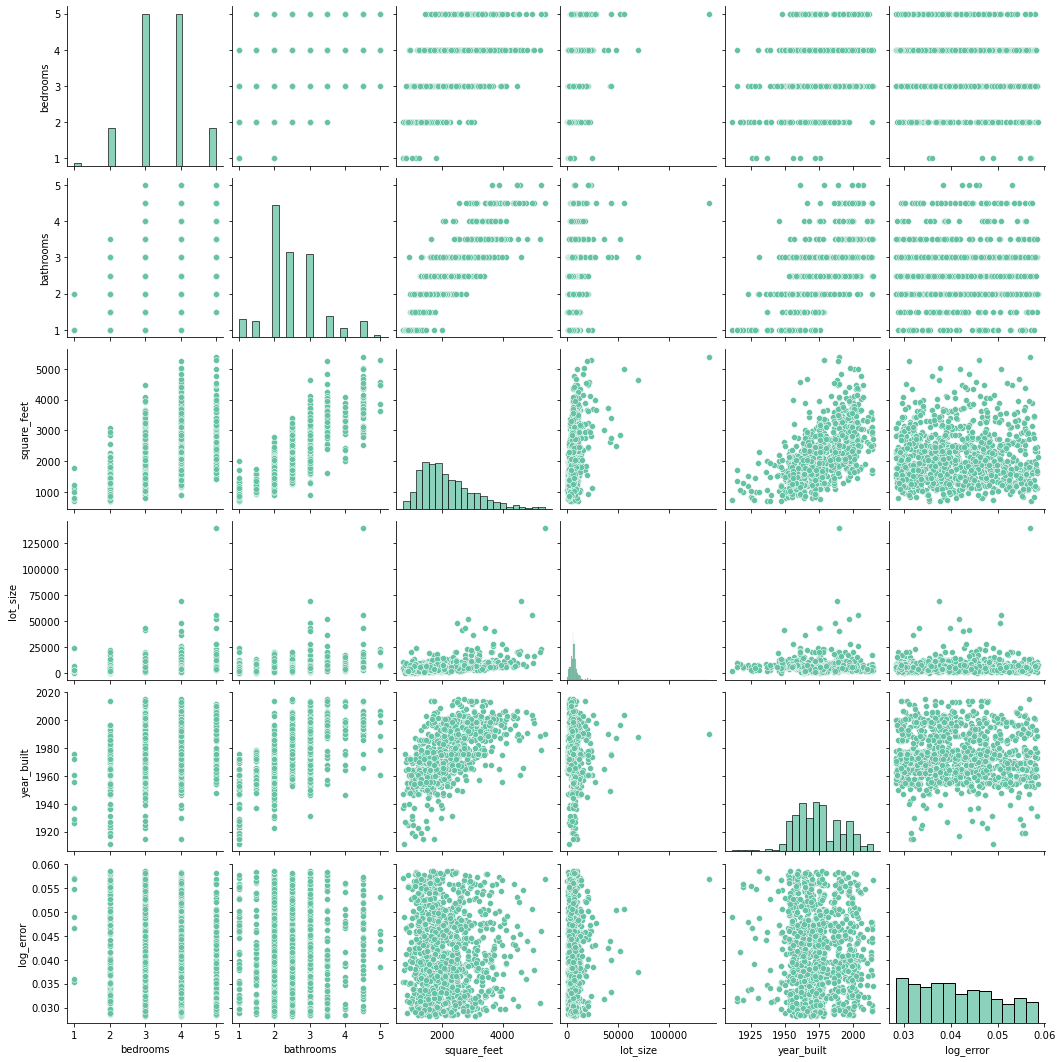

In [320]:
sns.pairplot(dp3)

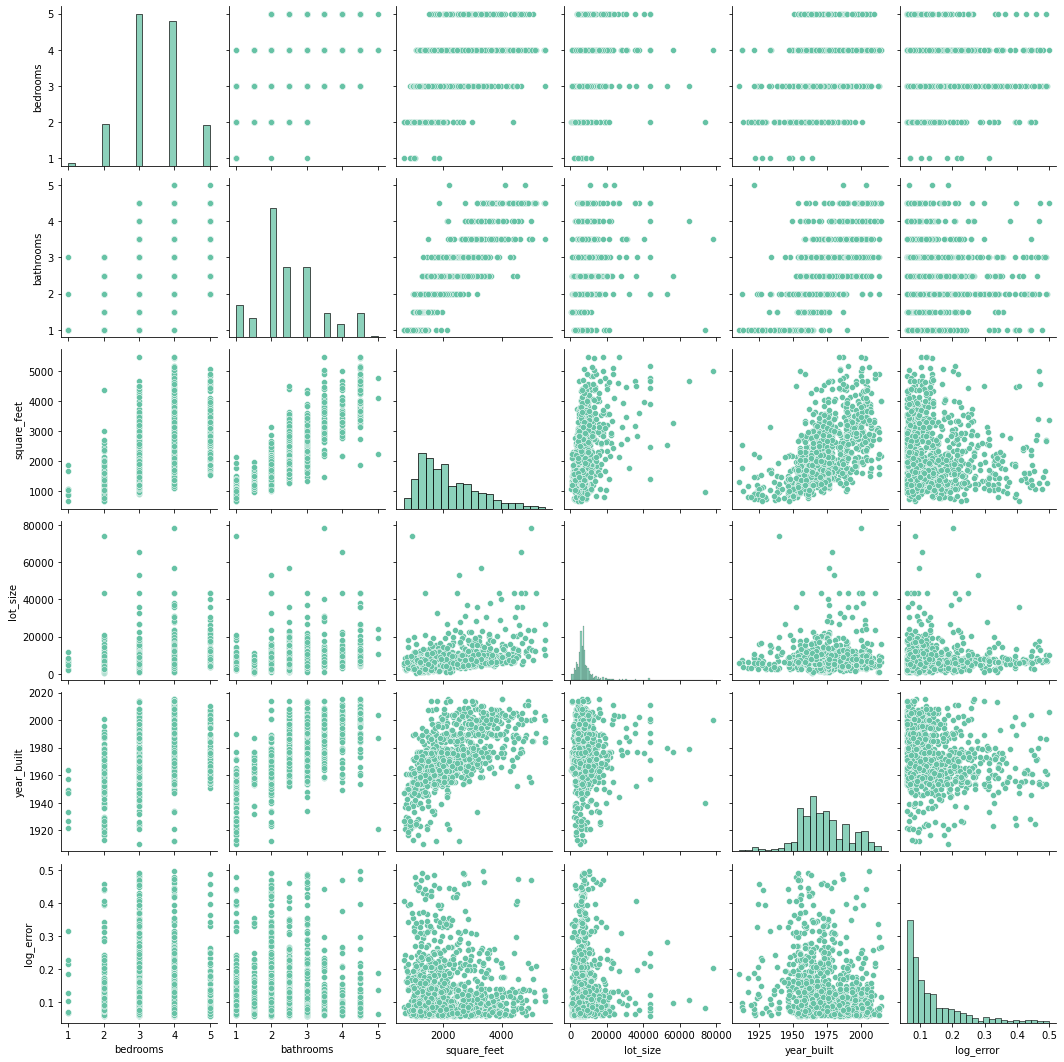

In [321]:
sns.pairplot(dp4)

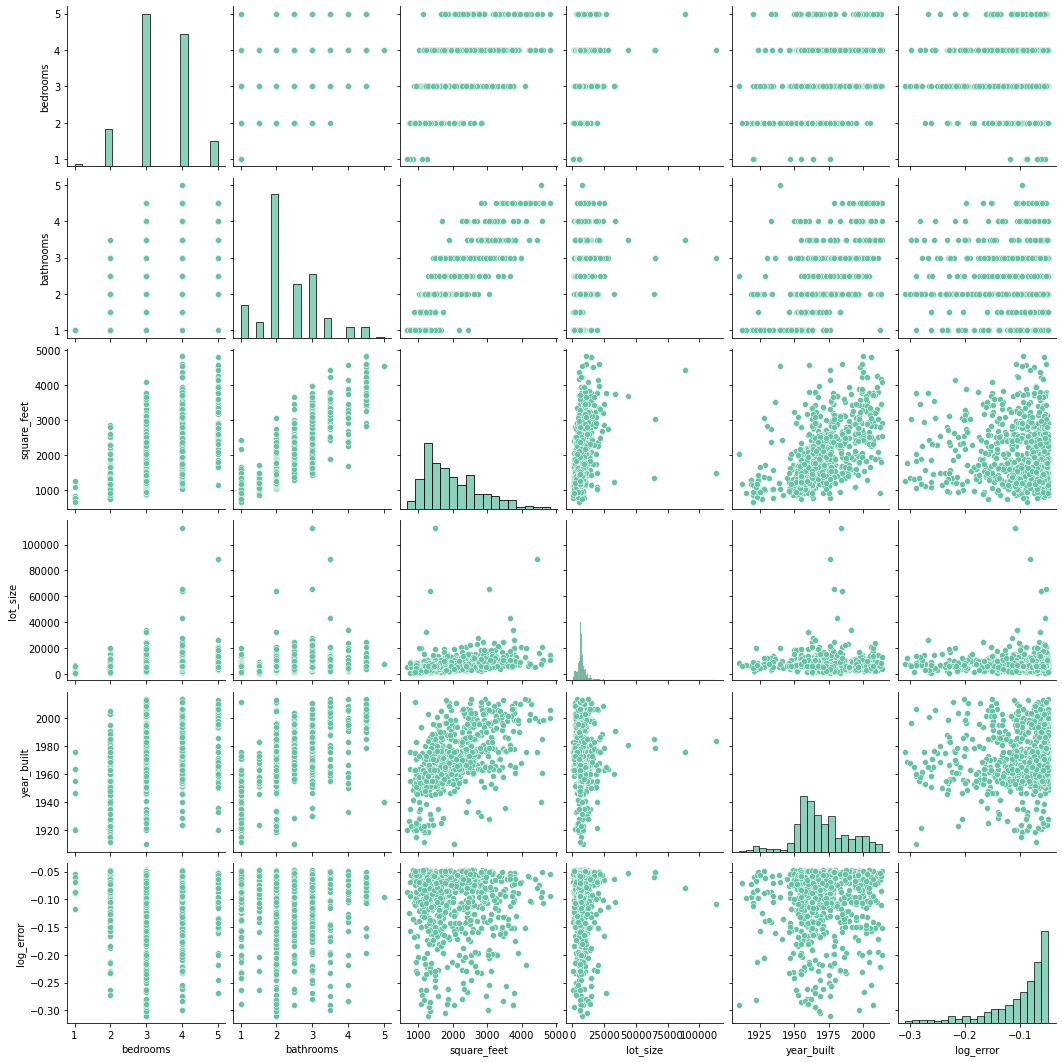

In [342]:
sns.pairplot(dn4)

Log error- higher for having gargage
higher for 1 bedroom and bit higher for 5 beds
higher for 4 + bathrooms
before 1949 has higher log error
square feet - I think it's greater for small and big
very low for having a pool

not
-landusecode

<AxesSubplot:title={'center':'Feature Correlation to Churn'}>

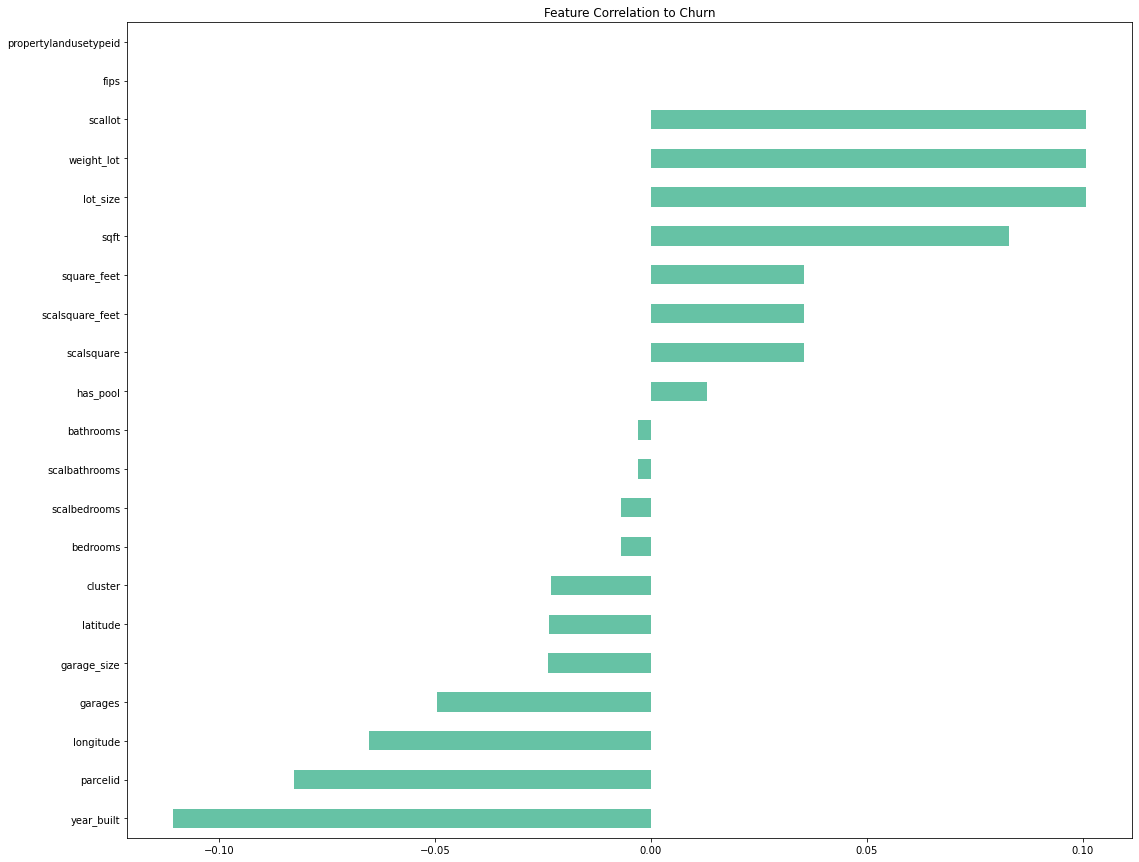

In [362]:
plt.figure(figsize=(18,15))
plt.title("Feature Correlation to Churn")
corr_chart = orange_train.drop("log_error", axis=1).corrwith(abs(orange_train['log_error'])).sort_values().plot.barh()
corr_chart

In [363]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [388]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['latitude', 'longitude', 'year_built']])
# inserts the 4 selected features into the scaler

orange_train[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_train[['latitude', 'longitude', 'year_built']])
orange_validate[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_validate[['latitude', 'longitude', 'year_built']])
orange_test[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_test[['latitude', 'longitude', 'year_built']])

In [389]:
#X = orange_train[['scallat', 'scallong', 'scallot']]

In [422]:
X = orange_train[['latitude', 'longitude']]

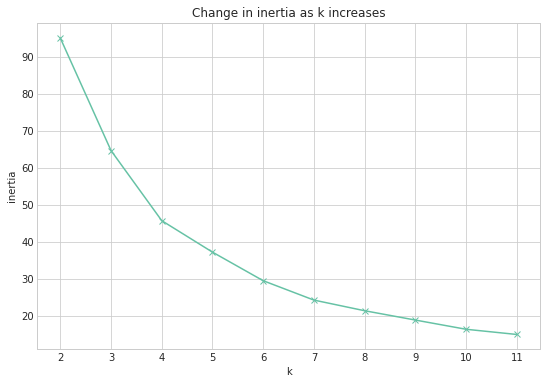

In [394]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(9, 6))
    pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 12)}).plot(marker='x')
    plt.xticks(range(2, 12))
    plt.xlabel('k')
    plt.ylabel('inertia')
    plt.title('Change in inertia as k increases')

In [ ]:
# scaler = sklearn.preprocessing.MinMaxScaler()
# scaler.fit(orange_train[['latitude', 'longitude', 'year_built']])
# # inserts the 4 selected features into the scaler

# orange_train[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_train[['latitude', 'longitude', 'year_built']])
# orange_validate[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_validate[['latitude', 'longitude', 'year_built']])
# orange_test[['scallat', 'scallong', 'scalyr']] = scaler.transform(orange_test[['latitude', 'longitude', 'year_built']])

In [424]:
X = orange_train[['latitude', 'longitude']]
XV = orange_validate[['latitude', 'longitude']]
XT = orange_test[['latitude', 'longitude']]

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)

kmeans.predict(X)

orange_train['locs'] = kmeans.predict(X)
orange_validate['locs'] = kmeans.predict(XV)
orange_test['locs'] = kmeans.predict(XT)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

latitude   longitude
0  33.869514 -117.854947
1  33.564358 -117.658954
2  33.770254 -117.992848
3  33.694866 -117.844336

In [425]:
orange_train.square_feet.groupby(orange_train.locs).mean()

locs
0    2024.038617
1    2296.377151
2    1702.919959
3    2123.648787
Name: square_feet, dtype: float64

In [426]:
bins = [1900, 1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2020]
labels = ['1910s','1920s','1930s','1940s', '1950s', '1960s', '1970s', '1980s', '1990s', '2000s', ]
orange_train['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_validate['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)
orange_test['year_bin'] = pd.cut(orange_train['year_built'], bins=bins, labels=labels)

Text(0.5, 1.0, 'Churn and Average Tenure in Months')

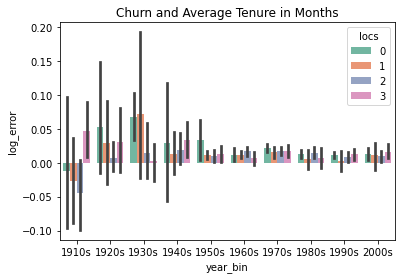

In [409]:
sns.barplot(data=orange_train, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [410]:
orange_train_neg = orange_train.where(orange_train.log_error < 0)
orange_train_pos = orange_train.where(orange_train.log_error > 0)

Text(0.5, 1.0, 'Churn and Average Tenure in Months')

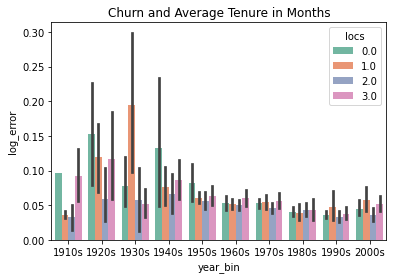

In [411]:
sns.barplot(data=orange_train_pos, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [416]:
# does location matter for year matter for? only in early years and also more for negative

Text(0.5, 1.0, 'Churn and Average Tenure in Months')

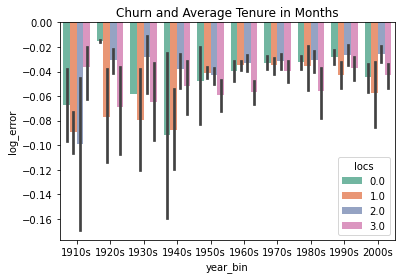

In [415]:
sns.barplot(data=orange_train_neg, x='year_bin', y='log_error', hue='locs')
plt.title("Churn and Average Tenure in Months")

In [417]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [440]:
orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7367 entries, 50705 to 1588
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   7367 non-null   float64       
 1   bathrooms                  7367 non-null   float64       
 2   bedrooms                   7367 non-null   float64       
 3   square_feet                7367 non-null   float64       
 4   fips                       7367 non-null   float64       
 5   garages                    7367 non-null   bool          
 6   garage_size                7367 non-null   float64       
 7   lot_size                   7367 non-null   float64       
 8   has_pool                   7367 non-null   int64         
 9   propertycountylandusecode  7367 non-null   object        
 10  propertylandusetypeid      7367 non-null   float64       
 11  year_built                 7367 non-null   float64       
 12  lo

CHECKPOINT

In [435]:
# dummy_train = pd.get_dummies(orange_train['propertycountylandusecode', 'cluster'])
# dummy_validate = pd.get_dummies(orange_validate['propertycountylandusecode', 'cluster'])
# dummy_test = pd.get_dummies(orange_test['log])

CategoricalDtype(categories=['N4', 'N3', 'N2', 'N1', 'P1', 'P2', 'P3', 'P4'], ordered=True)

In [464]:
X_train = orange_train[['bedrooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'has_pool','garages',  'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin 

X_test = orange_test[['bedrooms', 'has_pool', 'garages', 'bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

In [521]:
orange_train['rooms'] = (orange_train['bedrooms'] + orange_train['bathrooms'] + orange_train['garages'])
orange_validate['rooms'] = (orange_validate['bedrooms'] + orange_validate['bathrooms'] + orange_validate['garages'])
orange_test['rooms'] = (orange_test['bedrooms'] + orange_test['bathrooms'] + orange_test['garages'])

In [522]:
X_train = orange_train[['bedrooms', 'rooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error 

X_validate = orange_validate[['bedrooms', 'rooms', 'garages', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error

X_test = orange_test[['bedrooms', 'garages', 'rooms', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error

In [523]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_validate_scaled = scaler.transform(X_validate)
X_test_scaled = scaler.transform(X_test)

In [524]:
X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_validate_scaled = pd.DataFrame(X_validate_scaled, index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [550]:
from sklearn.feature_selection import SelectKBest, f_regression

f_selector = SelectKBest(f_regression, k=9)

f_selector.fit(X_train_scaled, y_train)

feature_mask = f_selector.get_support()
 
f_feature = X_train_scaled.iloc[:,feature_mask].columns.tolist()


In [551]:
f_feature

['bedrooms',
 'rooms',
 'garages',
 'has_pool',
 'bathrooms',
 'square_feet',
 'lot_size',
 'year_built',
 'sqft']

In [560]:
X_train = orange_train[['bedrooms', 'rooms', 'garages', 'has_pool', 'bathrooms', 'square_feet', 'lot_size', 'year_built', 'sqft', 'locs']]
y_train = orange_train.log_error_bin 

X_validate = orange_validate[['bedrooms', 'rooms', 'garages', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_validate = orange_validate.log_error_bin

X_test = orange_test[['bedrooms', 'garages', 'rooms', 'has_pool','bathrooms', 'square_feet',  'lot_size', 'year_built', 'sqft', 'locs']]
y_test = orange_test.log_error_bin

[Text(938.547794117647, 1528.875, 'sqft <= 0.851\ngini = 0.871\nsamples = 7367\nvalue = [763, 764, 760, 764, 1083, 1073, 1081, 1079]\nclass = P1'),
 Text(527.0414438502673, 1325.025, 'year_built <= 1976.5\ngini = 0.871\nsamples = 6558\nvalue = [716, 698, 682, 651, 1004, 979, 947, 881]\nclass = P1'),
 Text(285.34090909090907, 1121.175, 'year_built <= 1963.5\ngini = 0.873\nsamples = 4239\nvalue = [441, 450, 480, 483, 554, 567, 620, 644]\nclass = P4'),
 Text(143.22994652406416, 917.3249999999999, 'rooms <= 4.25\ngini = 0.871\nsamples = 2111\nvalue = [186, 223, 242, 303, 249, 265, 297, 346]\nclass = P4'),
 Text(71.61497326203208, 713.475, 'lot_size <= 8232.0\ngini = 0.842\nsamples = 233\nvalue = [15, 27, 22, 42, 19, 18, 27, 63]\nclass = P4'),
 Text(35.80748663101604, 509.625, 'lot_size <= 3589.0\ngini = 0.852\nsamples = 203\nvalue = [14, 26, 21, 39, 17, 18, 21, 47]\nclass = P4'),
 Text(17.90374331550802, 305.7750000000001, 'lot_size <= 2279.5\ngini = 0.735\nsamples = 34\nvalue = [0, 0, 4, 

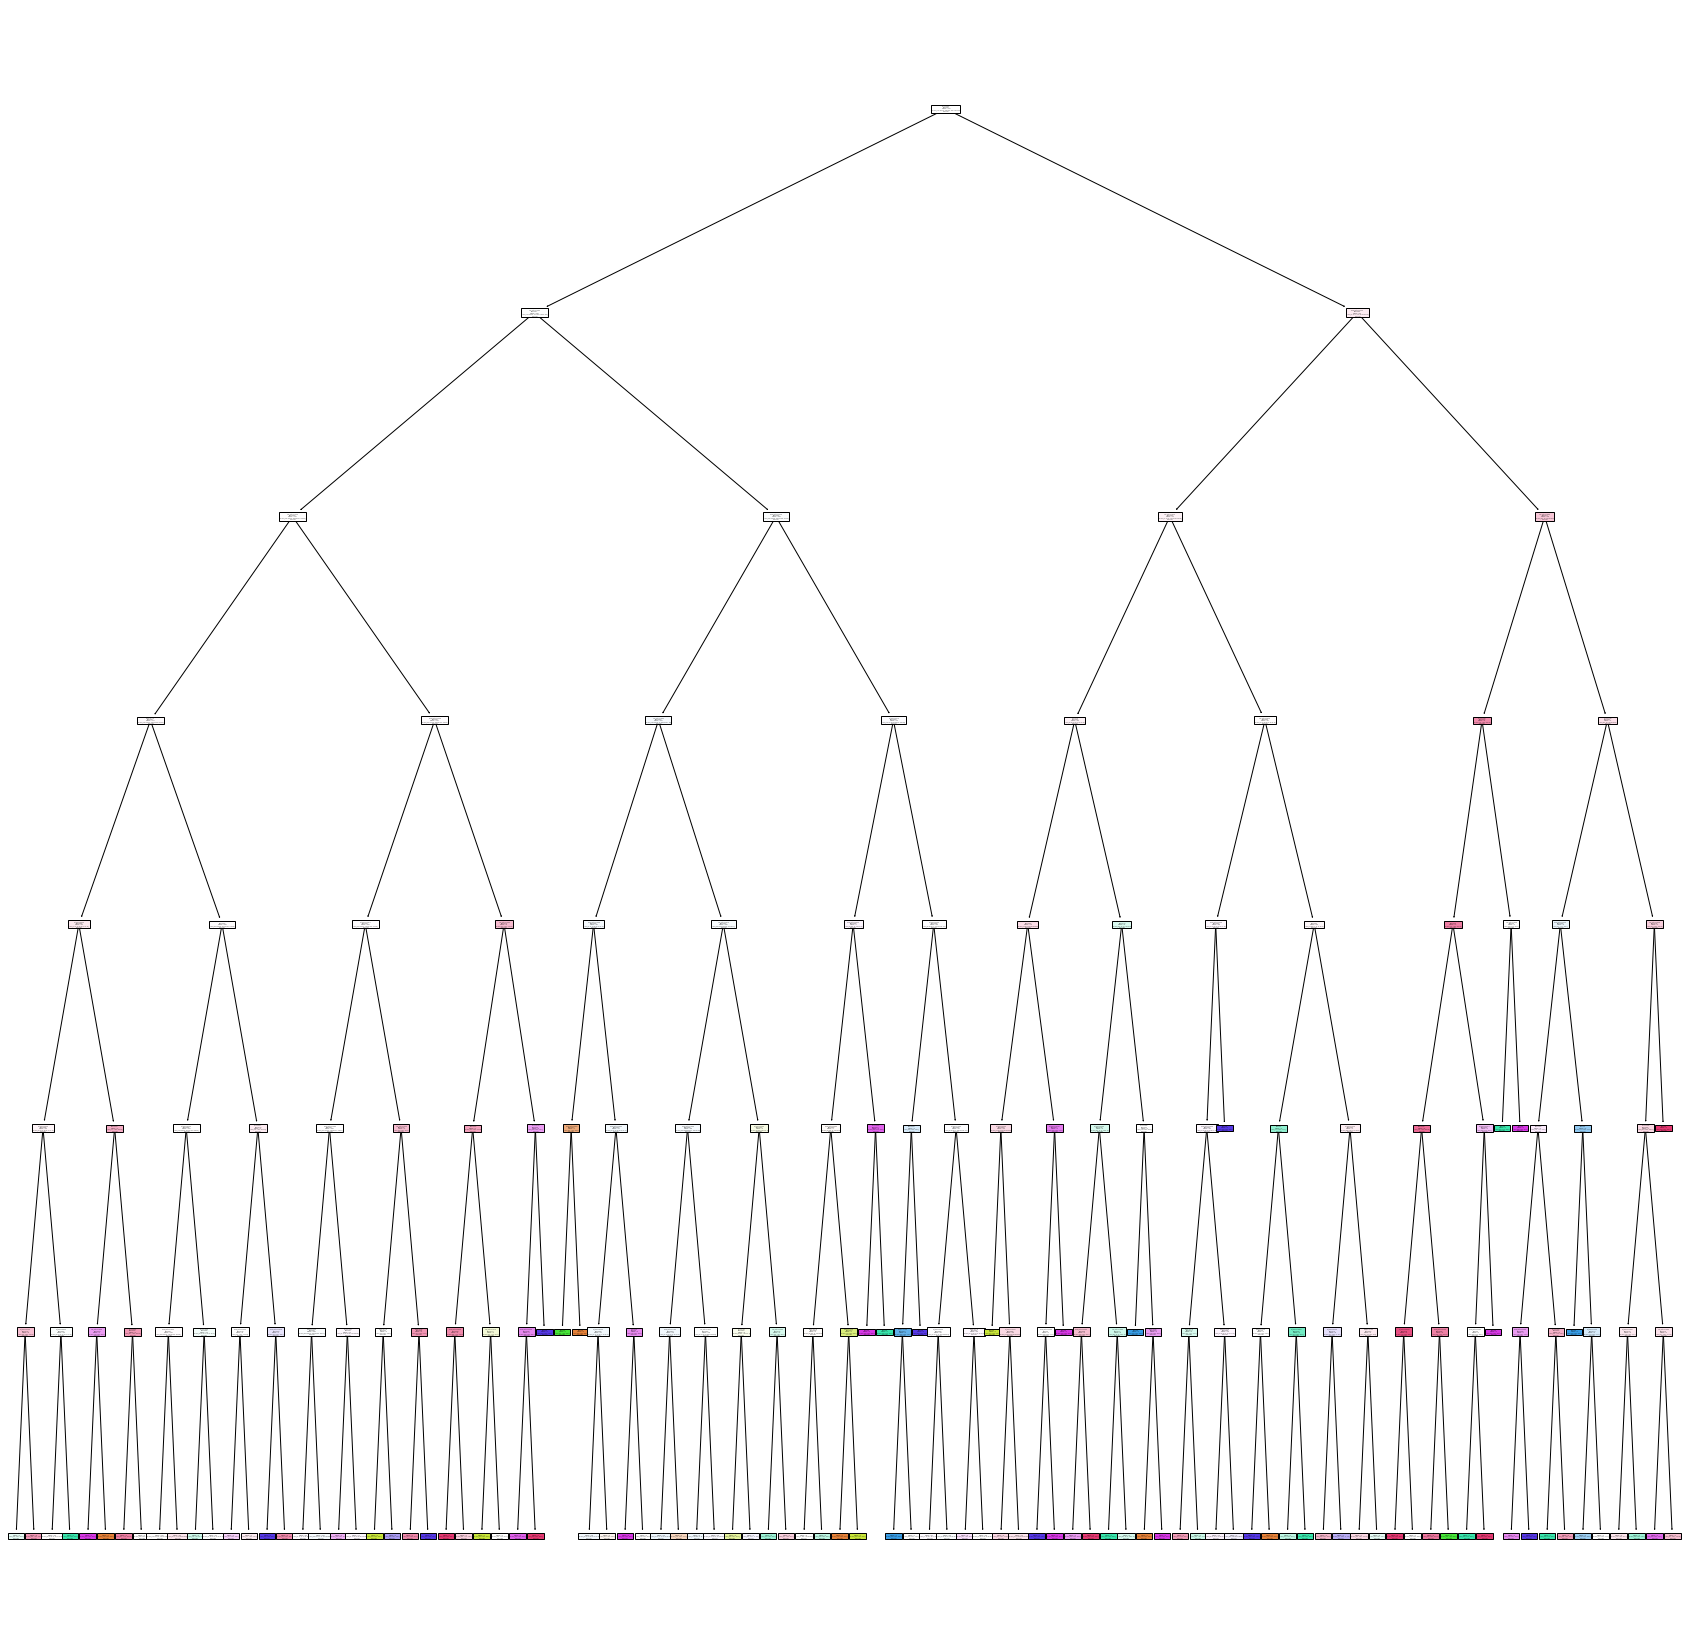

NameError: name 'class_names' is not defined

In [74]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [95]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_train[['scalbathrooms','scalsquare_feet']] = scaler.transform(orange_train[['bathrooms', 'square_feet']])

In [98]:
X = orange_train[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

scalbathrooms  scalsquare_feet
0       0.258378         0.182074
1       0.519799         0.461718
2       0.799048         0.659285
3       0.057075         0.098455
4       0.404798         0.297213

Text(0.5, 1.0, 'Change in inertia as k increases')

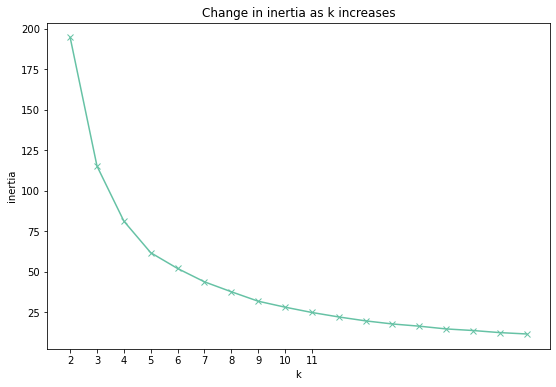

In [99]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

In [107]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_validate[['bathrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

orange_validate[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_validate[['bathrooms', 'square_feet']])

In [108]:
X = orange_validate[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_validate['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

scalbathrooms  scalsquare_feet
0       0.505037         0.461890
1       0.259159         0.175502
2       0.782751         0.645242
3       0.056439         0.099125
4       0.403448         0.287123

In [109]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_test[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_test[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_test[['bathrooms', 'square_feet']])

In [110]:
X = orange_test[['scalbathrooms',  'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_test['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

scalbathrooms  scalsquare_feet
0       0.416114         0.297598
1       0.258858         0.181864
2       0.791005         0.665695
3       0.059840         0.102443
4       0.503906         0.464248

In [83]:
orange_train

parcelid  bathrooms  bedrooms  square_feet    fips  garages  \
50705  14414316.0        3.0       4.0       2104.0  6059.0      2.0   
7085   14037285.0        1.5       3.0       1032.0  6059.0      2.0   
4560   14496831.0        3.0       3.0       1299.0  6059.0      2.0   
24504  14473040.0        2.0       4.0       2109.0  6059.0      2.0   
24460  14057077.0        2.0       5.0       1982.0  6059.0      2.0   
...           ...        ...       ...          ...     ...      ...   
16131  14144893.0        2.5       4.0       2655.0  6059.0      2.0   
40484  14076657.0        2.0       3.0       1439.0  6059.0      2.0   
7527   13931397.0        2.0       3.0       1889.0  6059.0      2.0   
50318  14036755.0        2.0       4.0       1454.0  6059.0      2.0   
1588   13961990.0        3.0       5.0       2305.0  6059.0      2.0   

       garage_size  lot_size has_pool propertycountylandusecode  ...  \
50705        441.0    4275.0    False                       122  ...   
7085         441.0    6000.0    False                       122  ...   
4560         440.0    3750.0    False                       122  ...   
24504        475.0    8449.0    False                       122  ...   
24460        506.0    6000.0     True                       122  ...   
...            ...       ...      ...                       ...  ...   
16131        493.0   19680.0     True                       122  ...   
40484        460.0    5000.0    False                       122  ...   
7527         400.0    8400.0     True                       122  ...   
50318        451.0    6000.0     True                       122  ...   
1588         416.0   13800.0    False                       122  ...   

       year_built  log_error  transaction_date  county   latitude   longitude  \
50705      1977.0   0.019273        2017-09-08  orange  33.554803 -117.701673   
7085       1962.0  -0.013230        2017-02-17  orange  33.738875 -118.016219   
4560       1986.0  -0.000039        2017-01-31  orange  33.651782 -117.576876   
24504      1966.0   0.078144        2017-05-16  orange  33.599907 -117.664683   
24460      1964.0  -0.019793        2017-05-15  orange  33.677214 -117.952371   
...           ...        ...               ...     ...        ...         ...   
16131      1964.0  -0.000091        2017-04-06  orange  33.894337 -117.939625   
40484      1971.0  -0.055627        2017-07-24  orange  33.714278 -117.942550   
7527       1955.0   0.011196        2017-02-21  orange  33.798431 -117.951018   
50318      1963.0  -0.057559        2017-09-07  orange  33.732223 -118.018982   
1588       2007.0  -0.062614        2017-01-11  orange  33.743353 -117.805178   

       scalbathrooms  scalbedrooms  scalsquare_feet  cluster  
50705          0.500          0.75         0.299731        3  
7085           0.125          0.50         0.078290        1  
4560           0.500          0.50         0.133444        0  
24504          0.250          0.75         0.300764        4  
24460          0.250          1.00         0.274530        4  
...              ...           ...              ...      ...  
16131          0.375          0.75         0.413551        3  
40484          0.250          0.50         0.162363        1  
7527           0.250          0.50         0.255319        1  
50318          0.250          0.75         0.165462        4  
1588           0.500          1.00         0.341252        2  

[7368 rows x 21 columns]

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

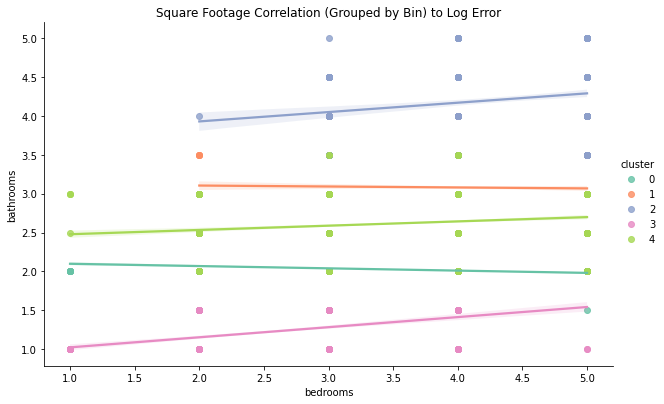

In [111]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='bedrooms', y='bathrooms', data=orange_train, scatter=True, hue='cluster', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Land Code w/Cont.')

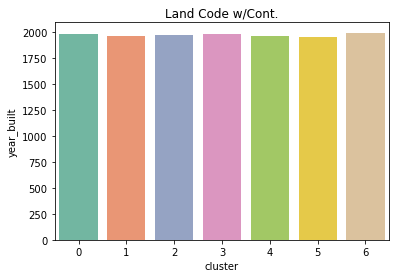

In [93]:
sns.barplot(data=orange_train, x='cluster', y='year_built')
plt.title("Land Code w/Cont.")

In [112]:
orange_train

parcelid  bathrooms  bedrooms  square_feet    fips  garages  \
50705  14414316.0        3.0       4.0       2104.0  6059.0      2.0   
7085   14037285.0        1.5       3.0       1032.0  6059.0      2.0   
4560   14496831.0        3.0       3.0       1299.0  6059.0      2.0   
24504  14473040.0        2.0       4.0       2109.0  6059.0      2.0   
24460  14057077.0        2.0       5.0       1982.0  6059.0      2.0   
...           ...        ...       ...          ...     ...      ...   
16131  14144893.0        2.5       4.0       2655.0  6059.0      2.0   
40484  14076657.0        2.0       3.0       1439.0  6059.0      2.0   
7527   13931397.0        2.0       3.0       1889.0  6059.0      2.0   
50318  14036755.0        2.0       4.0       1454.0  6059.0      2.0   
1588   13961990.0        3.0       5.0       2305.0  6059.0      2.0   

       garage_size  lot_size has_pool propertycountylandusecode  ...  \
50705        441.0    4275.0    False                       122  ...   
7085         441.0    6000.0    False                       122  ...   
4560         440.0    3750.0    False                       122  ...   
24504        475.0    8449.0    False                       122  ...   
24460        506.0    6000.0     True                       122  ...   
...            ...       ...      ...                       ...  ...   
16131        493.0   19680.0     True                       122  ...   
40484        460.0    5000.0    False                       122  ...   
7527         400.0    8400.0     True                       122  ...   
50318        451.0    6000.0     True                       122  ...   
1588         416.0   13800.0    False                       122  ...   

       year_built  log_error  transaction_date  county   latitude   longitude  \
50705      1977.0   0.019273        2017-09-08  orange  33.554803 -117.701673   
7085       1962.0  -0.013230        2017-02-17  orange  33.738875 -118.016219   
4560       1986.0  -0.000039        2017-01-31  orange  33.651782 -117.576876   
24504      1966.0   0.078144        2017-05-16  orange  33.599907 -117.664683   
24460      1964.0  -0.019793        2017-05-15  orange  33.677214 -117.952371   
...           ...        ...               ...     ...        ...         ...   
16131      1964.0  -0.000091        2017-04-06  orange  33.894337 -117.939625   
40484      1971.0  -0.055627        2017-07-24  orange  33.714278 -117.942550   
7527       1955.0   0.011196        2017-02-21  orange  33.798431 -117.951018   
50318      1963.0  -0.057559        2017-09-07  orange  33.732223 -118.018982   
1588       2007.0  -0.062614        2017-01-11  orange  33.743353 -117.805178   

       scalbathrooms  scalbedrooms  scalsquare_feet  cluster  
50705          0.500          0.75         0.299731        4  
7085           0.125          0.50         0.078290        3  
4560           0.500          0.50         0.133444        4  
24504          0.250          0.75         0.300764        0  
24460          0.250          1.00         0.274530        0  
...              ...           ...              ...      ...  
16131          0.375          0.75         0.413551        4  
40484          0.250          0.50         0.162363        0  
7527           0.250          0.50         0.255319        0  
50318          0.250          0.75         0.165462        0  
1588           0.500          1.00         0.341252        4  

[7368 rows x 21 columns]

In [116]:
dummy_train = pd.get_dummies(orange_train[['propertycountylandusecode', 'cluster']])
dummy_validate = pd.get_dummies(orange_validate[['propertycountylandusecode', 'cluster']])
dummy_test = pd.get_dummies(orange_test[['propertycountylandusecode', 'cluster']])

In [577]:
X_train

bedrooms  rooms  garages  has_pool  bathrooms  square_feet  lot_size  \
50705       4.0    8.0     True         0        3.0       2104.0    4275.0   
7085        3.0    5.5     True         0        1.5       1032.0    6000.0   
4560        3.0    7.0     True         0        3.0       1299.0    3750.0   
24504       4.0    7.0     True         0        2.0       2109.0    8449.0   
24460       5.0    8.0     True         1        2.0       1982.0    6000.0   
20138       3.0    5.0     True         1        1.0       1402.0    7503.0   
10398       4.0    8.0     True         0        3.0       2585.0    4749.0   
16693       3.0    6.0     True         0        2.0       1421.0    6800.0   
45662       2.0    5.0     True         0        2.0       1458.0    6600.0   
8322        3.0    6.5     True         0        2.5       2259.0    6075.0   
25732       2.0    4.5     True         0        1.5       1278.0    2458.0   
49133       3.0    6.0     True         0        2.0       1344.0    7200.0   
21498       4.0    8.0     True         0        3.0       2349.0    8960.0   
26456       4.0    8.0     True         0        3.0       1546.0    3480.0   
27097       3.0    7.0     True         0        3.0       2857.0   12750.0   
36913       2.0    5.0     True         0        2.0       1452.0    3600.0   
33947       3.0    5.5     True         0        1.5       1032.0    6000.0   
21336       4.0    9.5     True         0        4.5       4254.0   40000.0   
44132       4.0    7.5     True         0        2.5       2872.0   24668.0   
19283       3.0    6.0     True         0        2.0       1786.0    6890.0   
20327       3.0    6.5     True         0        2.5       1904.0    4493.0   
20902       4.0    8.0     True         0        3.0       1910.0    7875.0   
44258       5.0   10.5     True         0        4.5       4818.0   14674.0   
12659       2.0    5.0     True         1        2.0       1864.0    6996.0   
31695       4.0    7.5     True         0        2.5       3521.0    8250.0   
5791        4.0    7.5     True         1        2.5       1904.0    7500.0   
24928       3.0    7.0     True         0        3.0       2144.0    3240.0   
29845       3.0    6.0     True         0        2.0       1763.0    6000.0   
39791       5.0    9.0     True         0        3.0       2398.0   15000.0   
14446       1.0    3.0     True         0        1.0        904.0    1230.0   
15714       4.0    8.0     True         0        3.0       1897.0    4950.0   
11076       3.0    6.0     True         0        2.0       1697.0    6500.0   
17656       3.0    6.0     True         0        2.0       1373.0    6400.0   
33884       2.0    4.5     True         0        1.5       1110.0    1000.0   
16652       3.0    6.5     True         0        2.5       1397.0    4030.0   
9471        3.0    6.0     True         0        2.0       1539.0    5136.0   
48696       2.0    4.0     True         1        1.0        828.0    6025.0   
36605       3.0    6.0     True         0        2.0       1262.0    5850.0   
1620        4.0    7.5     True         0        2.5       2369.0    7062.0   
42880       2.0    5.0     True         1        2.0       1252.0    4725.0   
7150        5.0    9.0     True         0        3.0       2866.0    8880.0   
20317       2.0    4.5     True         0        1.5       1169.0     883.0   
10997       4.0    7.0     True         1        2.0       1289.0    6000.0   
44264       5.0   10.0     True         1        4.0       3831.0   13005.0   
14368       4.0    8.0     True         1        3.0       2253.0   10880.0   
4212        4.0    7.5     True         0        2.5       2392.0    4448.0   
29406       3.0    4.0    False         0        1.0        960.0    7234.0   
11907       5.0    8.5     True         0        2.5       2113.0    5917.0   
14415       4.0    7.0     True         1        2.0       2153.0    7738.0   
38725       3.0    6.0     True         0        2.0     

In [583]:
X_train = orange_train[['sqft', 'has_pool', 'rooms']]
y_train = orange_train[['log_error']]

X_validate = orange_validate[['sqft', 'has_pool', 'rooms']]
y_validate = orange_validate[['log_error']]

X_test = orange_test[['sqft', 'has_pool', 'rooms']]
y_test = orange_test[['log_error']]

In [584]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train[['sqft', 'has_pool', 'rooms']])

MinMaxScaler()

In [585]:
X_train[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_train[['sqft', 'has_pool', 'rooms']]) 
X_validate[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_validate[['sqft', 'has_pool', 'rooms']]) 
X_test[['scalsqft', 'scalhas_pool', 'scalrooms']] = scaler.transform(X_test[['sqft', 'has_pool', 'rooms']]) 

In [120]:
# v = pd.DataFrame(data = v)
# v1 = pd.DataFrame(data = v1)
# v2 = pd.DataFrame(data = v2)

In [121]:
# v.index = X_train.index
# v1.index = X_validate.index
# v2.index = X_test.index

In [122]:
# X_train = pd.concat([X_train, v], axis=1)
# X_validate = pd.concat([X_validate, v1], axis=1)
# X_test = pd.concat([X_test, v2], axis=1)

In [586]:
X_train

sqft  has_pool  rooms  scalsqft  scalhas_pool  scalrooms
50705  -0.211766         0    8.0  0.074051           0.0   0.666667
7085   -0.717380         0    5.5  0.041465           0.0   0.388889
4560   -0.757597         0    7.0  0.038873           0.0   0.555556
24504   0.172298         0    7.0  0.098803           0.0   0.555556
24460  -0.129781         1    8.0  0.079334           1.0   0.666667
20138  -0.351343         1    5.0  0.065055           1.0   0.333333
10398   0.129008         0    8.0  0.096013           0.0   0.666667
16693  -0.403756         0    6.0  0.061677           0.0   0.444444
45662  -0.399125         0    5.0  0.061976           0.0   0.333333
8322    0.048396         0    6.5  0.090817           0.0   0.500000
25732  -0.888510         0    4.5  0.030436           0.0   0.277778
49133  -0.414874         0    6.0  0.060961           0.0   0.444444
21498   0.367384         0    8.0  0.111376           0.0   0.666667
26456  -0.629465         0    8.0  0.047131           0.0   0.666667
27097   1.027518         0    7.0  0.153920           0.0   0.555556
36913  -0.676654         0    5.0  0.044089           0.0   0.333333
33947  -0.717380         0    5.5  0.041465           0.0   0.388889
21336   4.378774         0    9.5  0.369901           0.0   0.833333
44132   2.124581         0    7.5  0.224623           0.0   0.611111
19283  -0.169780         0    6.0  0.076756           0.0   0.444444
20327  -0.315574         0    6.5  0.067360           0.0   0.500000
20902  -0.003179         0    8.0  0.087493           0.0   0.666667
44258   2.416054         0   10.5  0.243408           0.0   0.944444
12659  -0.111860         1    5.0  0.080489           1.0   0.333333
31695   1.027492         0    7.5  0.153918           0.0   0.611111
5791   -0.041118         1    7.5  0.085048           1.0   0.611111
24928  -0.281492         0    7.0  0.069557           0.0   0.555556
29845  -0.265238         0    6.0  0.070604           0.0   0.444444
39791   0.948978         0    9.0  0.148858           0.0   0.777778
14446  -1.231922         0    3.0  0.008304           0.0   0.111111
15714  -0.278192         0    8.0  0.069769           0.0   0.666667
11076  -0.260425         0    6.0  0.070915           0.0   0.444444
17656  -0.469954         0    6.0  0.057411           0.0   0.444444
33884  -1.125498         0    4.5  0.015162           0.0   0.277778
16652  -0.671426         0    6.5  0.044426           0.0   0.500000
9471   -0.482648         0    6.0  0.056593           0.0   0.444444
48696  -0.841278         1    4.0  0.033480           1.0   0.222222
36605  -0.588810         0    6.0  0.049751           0.0   0.444444
1620    0.206519         0    7.5  0.101008           0.0   0.611111
42880  -0.697677         1    5.0  0.042735           1.0   0.333333
7150    0.679860         0    9.0  0.131514           0.0   0.777778
20317  -1.099684         0    4.5  0.016826           0.0   0.277778
10997  -0.558419         1    7.0  0.051709           1.0   0.555556
44264   1.653236         1   10.0  0.194246           1.0   0.888889
14368   0.483249         1    8.0  0.118843           1.0   0.666667
4212   -0.017841         0    7.5  0.086549           0.0   0.611111
29406  -0.649284         0    4.0  0.045853           0.0   0.222222
11907  -0.056330         0    8.5  0.084068           0.0   0.722222
14415   0.134618         1    7.0  0.096374           1.0   0.555556
38725  -0.604535         0    6.0  0.048737           0.0   0.444444
49106   3.175792         0    9.5  0.292371           0.0   0.833333
13706  -0.347502         0    6.0  0.065303           0.0   0.444444
44104  -0.486142         0    5.0  0.056368           0.0   0.333333
40636  -0.302598         1    7.0  0.068197           1.0   0.555556
8049   -0.601716         0    5.5  0.048919           0.0   0.388889
13659   0.804461         0    7.5  0.139544           0.0   0.611111
782     0.138513         0    7.5  0.096625           0.0   0.611111
32463   0.

In [587]:
X_train = X_train.drop(columns=['sqft', 'has_pool', 'rooms'])
y_train = y_train[['log_error']]

X_validate = X_validate.drop(columns=['sqft', 'has_pool', 'rooms'])
y_validate = y_validate[['log_error']]

X_test = X_test.drop(columns=['sqft', 'has_pool', 'rooms'])
y_test = y_test[['log_error']]

In [590]:
X_train.head()

scalsqft  scalhas_pool  scalrooms
50705  0.074051           0.0   0.666667
7085   0.041465           0.0   0.388889
4560   0.038873           0.0   0.555556
24504  0.098803           0.0   0.555556
24460  0.079334           1.0   0.666667

In [588]:
y_train['pred_mean'] = y_train.log_error.mean()
y_validate['pred_mean'] = y_validate.log_error.mean()

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 4)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

Baseline RMSE
Train/In-Sample:  0.0756
Baseline RMSE
Validate/Out-of-Sample:  0.0715


In [591]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train.log_error)

y_train['value_predict_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)

y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)


printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

**OLS Linear Regression Performance**

---------------------------------------
RMSE for OLS using LinearRegression
Training/In-Sample:  0.0753
---------------------------------------
RMSE for OLS using LinearRegression
Validation/Out-of-Sample:  0.0714


In [592]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train, y_train.log_error)

y_train['pred_lars'] = lars.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_lars)**(1/2)

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 4))

**LARS Performance**

---------------------------------------
RMSE for Lars
Training/In-Sample:  0.0756
---------------------------------------
RMSE for Lars
Out-of-Sample:  0.0715


In [593]:
pf = PolynomialFeatures(degree=2)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [594]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 4)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 4))

**Polynomial Regression Model Performance**

---------------------------------------
RMSE for Polynomial Model 
Training/In-Sample:  0.0753
---------------------------------------
RMSE for Polynomial Model, 
Validation/Out-of-Sample:  0.0714
